In [ ]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\aluminum\2021-03-30_cts\3_normal\DIC_img\data'

for i=1:1:4
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end
"""

In [2]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
sys.path

['C:\\Users\\Mechano_2\\PycharmProjects',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\python37.zip',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\DLLs',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final',
 '',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Mechano_2\\.ipython',
 'C:\\Users\\Mechano_2\\PycharmProjects\\pro']

3-j_integral(kj/m^2)_ml: 36.845933333982316
3-j_integral(kj/m^2)_dic: 30.045534716410742


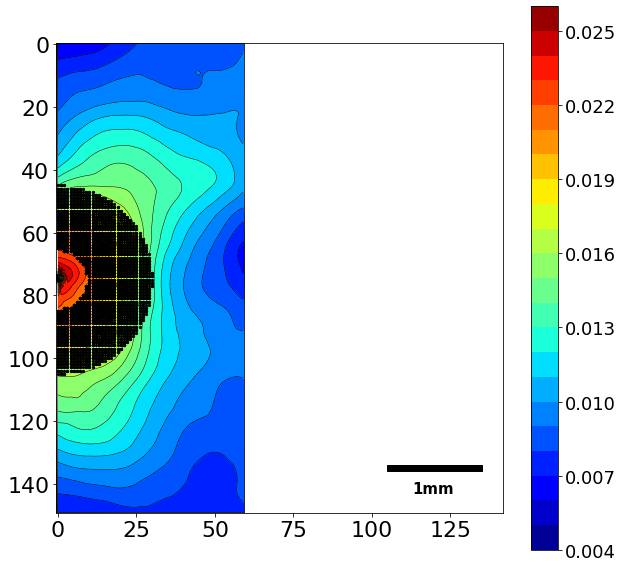

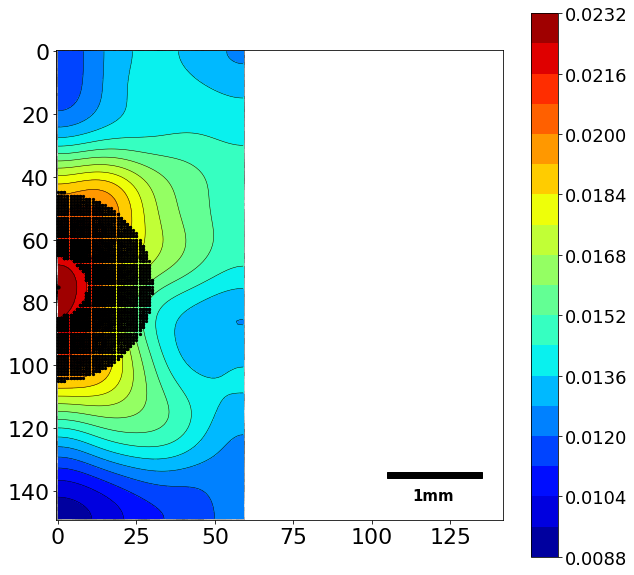

In [10]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture as fracture
from scipy import io
import matplotlib.patches as patches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000
ml_slope=150

# Img parameter
contour_level = 20
ratio = 2/60
left, right, up_down = 0,60,75

#DIC parameter
scale_factor=2

# pick point
radius_gap = 1
gap_count = 22
start_gap = 0.32

deg=90
num= 3         #####


path =r'E:\experiment data\aluminum\2021-03-30_cts\3_normal'
crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x

##data load part##
image = dic.load_file(path+'/img')
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
uu = io.loadmat(path+'/DIC_img/data'+'/'+str(num)+'_uu.mat')['uu']
vv = io.loadmat(path+'/DIC_img/data'+'/'+str(num)+'_vv.mat')['vv']
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )
exx = io.loadmat(path+'/DIC_img/data'+'/'+str(num)+'_exx.mat')['exx']
eyy = io.loadmat(path+'/DIC_img/data'+'/'+str(num)+'_eyy.mat')['eyy']
exy = io.loadmat(path+'/DIC_img/data'+'/'+str(num)+'_exy.mat')['exy']
ee = fracture.effective_strain(exx, eyy, exy)
exx_resize = cv2.resize(exx,(0,0),fx=scale_factor, fy=scale_factor )
eyy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )
exy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )
ee_resize = cv2.resize(ee,(0,0),fx=scale_factor, fy=scale_factor )

eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))


##ML part##
ref = list(image.keys())[0]
cur = list(image.keys())[num]
src_reference = image[ref][:,:,1][crack_tip[0][0]-up_down:crack_tip[0][0]+up_down,crack_tip[0][1]-left:crack_tip[0][1]+right]
src_current = image[cur][:,:,1][crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]

max_crack_tip = [left,up_down]

dst = cv2.subtract(src_current.astype('float64'),src_reference.astype('float64'))
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
dst = np.where(dst<0, dst*0, dst)
gas = cv2.GaussianBlur(dst,(0,0),10)

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,deg,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,deg,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r*0.001

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_strain = np.append(effective_strain, current_ml/ml_slope)
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df['ml'] = ml
df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus


print('{}-j_integral(kj/m^2)_ml:'.format(num), 1000*j_integral)

###DIC###
dst_dic = ee_resize[crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]
dst_dic = dst_dic.astype(float)
dst_dic = np.where(dst_dic>10, dst_dic*0, dst_dic)
dic_gas = dst_dic

max_crack_tip = [left, up_down]

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,deg,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,deg,0)))
        radius_g += radius_gap

df_dic = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df_dic.x = df_dic.x + max_crack_tip[0]
df_dic.y = df_dic.y + max_crack_tip[1]
df_dic.r = df_dic.r*0.001


hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df_dic[['y','x','angle']]):
    effective_strain = dic_gas[np.round(y).astype(int),np.round(x).astype(int)]
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df_dic['effective_strain'] = effective_strain
df_dic['hardening_strain_bar'] = theta_list

plastic_k = np.power(df_dic.effective_strain * youngs_modulus
                     / (df_dic.hardening_strain_bar * alpha * yield_strength *
                        np.power(df_dic.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus))

print('{}-j_integral(kj/m^2)_dic:'.format(num), 1000*j_integral)


###DIC 그래프###
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 113,143, '1mm', fontsize=15, fontweight='bold')
ax.imshow(dic_gas, cmap='gray')
csf = ax.contourf(dic_gas, contour_level, cmap = 'jet')
CS = ax.contour(dic_gas, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)

# ax.axis('off')
plt.scatter(df_dic['x'],df_dic['y'],color='black',s=5)
plt.scatter(left, up_down, s = 10,  c = 'black')

plt.savefig(path+'/{}_basic.png'.format(num), dpi=300,bbox_inches='tight')
plt.show()
plt.close()


###ML그래프###
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = ax.contourf(gas/150, contour_level, cmap = 'jet')
CS = ax.contour(gas/150, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)
plt.scatter(left, up_down, s = 10,  c = 'black')
plt.scatter(df.x, df.y, s = 5,  c='black')
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 113,143, '1mm', fontsize=15, fontweight='bold')
plt.savefig(path+'/{}_basic.png'.format(num), dpi=300,bbox_inches='tight')
plt.show()
plt.close()